# 4족로봇 시뮬레이터 테스트

[link](https://github.com/OpenQuadruped/spot_mini_mini/blob/spot/spot_bullet/src/env_tester.py)

210513

In [1]:
# load library
#!/usr/bin/env python

import numpy as np
import matplotlib.pyplot as plt
import copy

import sys

sys.path.append('../../')

from spotmicro.GymEnvs.spot_bezier_env import spotBezierEnv
from spotmicro.util.gui import GUI
from spotmicro.Kinematics.SpotKinematics import SpotModel
from spotmicro.Kinematics.LieAlgebra import RPY
from spotmicro.GaitGenerator.Bezier import BezierGait
from spotmicro.spot_env_randomizer import SpotEnvRandomizer

# TESTING
from spotmicro.OpenLoopSM.SpotOL import BezierStepper

import time
import os

import argparse


../..\spotmicro\util\pybullet_data


In [2]:
# load config
class config:
    def __init__(self):
        self.DebugRack=False  # Put Spot on an Elevated Rack
        self.DebugPath=False  # Draw Spot's Foot Path
        self.HeightField=False  # Use HeightField
        self.DontRandomize=False  # Do NOT Randomize State and Environment.
        self.AutoYaw=False  # Automatically Adjust Spot's Yaw
        self.AutoReset=False  # Automatically Reset Environment When Spot Falls

ARGS=config()

# set config
print("STARTING SPOT TEST ENV")
seed = 0
max_timesteps = 4e6

# Find abs path to this file
my_path = os.getcwd()  # 내 현 위치
results_path = os.path.join(my_path, "../results")
models_path = os.path.join(my_path, "../models")

if not os.path.exists(results_path):
    os.makedirs(results_path)

if not os.path.exists(models_path):
    os.makedirs(models_path)

# set config
if ARGS.DebugRack:
    on_rack = True
else:
    on_rack = False

if ARGS.DebugPath:
    draw_foot_path = True
else:
    draw_foot_path = False

if ARGS.HeightField:
    height_field = True
else:
    height_field = False

if ARGS.DontRandomize:
    env_randomizer = None
else:
    env_randomizer = SpotEnvRandomizer()

STARTING SPOT TEST ENV


In [3]:
# GUI 창 띄우기
env = spotBezierEnv(render=True,
                    on_rack=on_rack,
                    height_field=height_field,
                    draw_foot_path=draw_foot_path,
                    env_randomizer=env_randomizer)

# Set seeds
env.seed(seed)
np.random.seed(seed)

state_dim = env.observation_space.shape[0]
print("STATE DIM: {}".format(state_dim))
action_dim = env.action_space.shape[0]
print("ACTION DIM: {}".format(action_dim))
max_action = float(env.action_space.high[0])

# state : [IMU_Roll, IMU_Pitch, IMU_GX, IMU_GY, IMU_GZ, IMU_AX, IMU_AY, IMU_AZ]
# state : [0.0,       -0.0,      0.0,    0.0,    0.0,    0,      0,     0,       0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0]
state = env.reset()
   
    
g_u_i = GUI(env.spot.quadruped)  # 오른쪽 Params에 x, y, z, roll, pitch 등 가져오기

spot = SpotModel()  # kinematics(운동학)를 불러온다
T_bf0 = spot.WorldToFoot  # 
T_bf = copy.deepcopy(T_bf0)

bzg = BezierGait(dt=env._time_step)  # High speed trot-running: Implementation of a hierarchical controller using proprioceptive impedance control on the MIT Cheetah
bz_step = BezierStepper(dt=env._time_step, mode=0)

# action = array([ 0.07783558,  0.42717528,  0.8579016 ,  0.967464  ,  0.411128  ,
#                -0.28735796, -0.81569785, -0.06614858, -0.8572826 ,  0.09210487,
#                 0.4450293 ,  0.65074676, -0.05096681, -0.9734769 ], dtype=float32)
action = env.action_space.sample()

FL_phases, FR_phases, BL_phases, BR_phases = [], [], [], []
FL_Elbow = []
save_joint_angles = []  # 실행중 모든 joint 각도를 저장하자(degree)

yaw = 0.0

[9, 13, 18, 22]
Action SPACE: Box(14,)
STATE DIM: 16
ACTION DIM: 14


C:\Users\go\.conda\envs\venv\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [4]:
# 모든 다리 초기값 : -0.0, 39.7532325075732, -75.21234325859432
# 일단 초기 다리각도가 그림과 같아지도록 맞추자
# start!
print("STARTED SPOT TEST ENV")
t = 0
while t < (int(max_timesteps)):
    # 1s에 100번 돈다
#     if t > 100:  break
    
    bz_step.ramp_up()

    pos, orn, StepLength, LateralFraction, YawRate, \
        StepVelocity, ClearanceHeight, PenetrationDepth = bz_step.StateMachine()  # 환경에서 각 값들을 불러온다

    pos, orn, StepLength, LateralFraction, YawRate, \
        StepVelocity, ClearanceHeight, PenetrationDepth, SwingPeriod = g_u_i.UserInput()  # 오른쪽 창에 입력한걸 불러온다

#     StepLength = 0.025  # 전진
    
    # Update Swing Period
    bzg.Tswing = SwingPeriod  # 0.2

    yaw = env.return_yaw()  # 계속 변한다, 환경에서 가져온다
    
    P_yaw = 5.0  # 뭐지?

    if ARGS.AutoYaw:
        YawRate += -yaw * P_yaw

    # print("YAW RATE: {}".format(YawRate))

    # TEMP
    bz_step.StepLength = StepLength
    bz_step.LateralFraction = LateralFraction
    bz_step.YawRate = YawRate
    bz_step.StepVelocity = StepVelocity

    
    contacts = state[-4:]  # array([1., 1., 1., 1.])

    # env.spot.LegPhases = [0.0, 0.5, 0.5, 0.0]
    FL_phases.append(env.spot.LegPhases[0])
    FR_phases.append(env.spot.LegPhases[1])
    BL_phases.append(env.spot.LegPhases[2])
    BR_phases.append(env.spot.LegPhases[3])    
    
    # Get Desired Foot Poses
#     T_bf = OrderedDict([('FL',
#                           array([[ 1.        ,  0.        ,  0.        ,  0.10334008],
#                                  [ 0.        ,  1.        ,  0.        ,  0.0925    ],
#                                  [ 0.        ,  0.        ,  1.        , -0.20224553],
#                                  [ 0.        ,  0.        ,  0.        ,  1.        ]])),
#                          ('FR',
#                           array([[ 1.        ,  0.        ,  0.        ,  0.14503211],
#                                  [ 0.        ,  1.        ,  0.        , -0.0925    ],
#                                  [ 0.        ,  0.        ,  1.        , -0.13379757],
#                                  [ 0.        ,  0.        ,  0.        ,  1.        ]])),
#                          ('BL',
#                           array([[ 1.        ,  0.        ,  0.        , -0.08496789],
#                                  [ 0.        ,  1.        ,  0.        ,  0.0925    ],
#                                  [ 0.        ,  0.        ,  1.        , -0.13379757],
#                                  [ 0.        ,  0.        ,  0.        ,  1.        ]])),
#                          ('BR',
#                           array([[ 1.        ,  0.        ,  0.        , -0.12665992],
#                                  [ 0.        ,  1.        ,  0.        , -0.0925    ],
#                                  [ 0.        ,  0.        ,  1.        , -0.20224553],
#                                  [ 0.        ,  0.        ,  0.        ,  1.        ]]))])    
    
    T_bf = bzg.GenerateTrajectory(StepLength, LateralFraction, YawRate,
                                  StepVelocity, T_bf0, T_bf,
                                  ClearanceHeight, PenetrationDepth,
                                  contacts)
# joint_angles = array([[-0.        ,  0.6938248 , -1.31270303],   FL(어깨(좌우, -가 안쪽, ), 어깨(앞뒤), 팔꿈치(앞뒤))
#                        [-0.        ,  0.6938248 , -1.31270303],  FE
#                        [-0.        ,  0.6938248 , -1.31270303],  BL
#                        [-0.        ,  0.6938248 , -1.31270303]]) BR    
    joint_angles = spot.IK(orn, pos, T_bf)  # position to angle, !! 여기 공부하자

    FL_Elbow.append(np.degrees(joint_angles[0][-1]))  # 75도
    save_joint_angles.append(joint_angles)
    
#     # 각도 plot
#     for i, (key, Tbf_in) in enumerate(T_bf.items()):
#         print("{}: \t Angle: {}".format(key, np.degrees(joint_angles[i])))
#     print("-------------------------")

#     joint_angles[0][0] = +1

    env.pass_joint_angles(joint_angles.reshape(-1))
    # Get External Observations
    env.spot.GetExternalObservations(bzg, bz_step)
    # Step
    state, reward, done, _ = env.step(action)  # 매 step마다 state 갱신
#     print('Roll/Pitch/GX/GY/GZ/AX/AY/AZ : %.4f/%.4f/%.4f/%.4f/%.4f/%.4f/%.4f/%.4f'%(state[0], state[1], state[2], state[3], state[4], state[5], state[6], state[7]))
    
    if done:
        print("DONE")
        if ARGS.AutoReset:
            env.reset()
            # plt.plot()
            # plt.plot(FL_phases, label="FL")
            # plt.plot(FR_phases, label="FR")
            # plt.plot(BL_phases, label="BL")
            # plt.plot(BR_phases, label="BR")
            plt.plot(FL_Elbow, label="FL ELbow (Deg)")
            plt.xlabel("dt")
            plt.ylabel("value")
            plt.title("Leg Phases")
            plt.legend()
            plt.show()

    # time.sleep(1.0)

    t += 1
env.close()
# joint angle(radian to degree)
Front_Left, Front_Right, Back_Left, Back_Right = [], [], [], []
for idx, joint_angles in enumerate(save_joint_angles):
    Front_Left.append([np.degrees(tmp) for tmp in joint_angles[0]])
    Front_Right.append([np.degrees(tmp) for tmp in joint_angles[1]])
    Back_Left.append([np.degrees(tmp) for tmp in joint_angles[2]])
    Back_Right.append([np.degrees(tmp) for tmp in joint_angles[3]])

# plot
plt.plot()
plt.plot(Front_Left, label="FL")
plt.plot(Front_Right, label="FR")
plt.plot(Back_Left, label="BL")
plt.plot(Back_Right, label="BR")
# plt.plot(Front_Left, label="FL ELbow (Deg)")
plt.xlabel("dt")
plt.ylabel("degree")
plt.title("Leg Phases")
plt.legend()
plt.show()

STARTED SPOT TEST ENV
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DON

KeyboardInterrupt: 

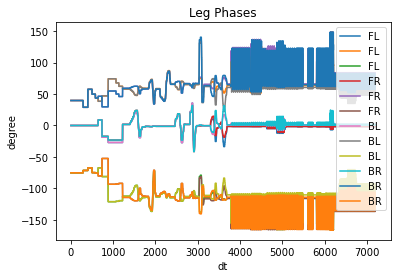

In [5]:
env.close()
# joint angle(radian to degree)
Front_Left, Front_Right, Back_Left, Back_Right = [], [], [], []
for idx, joint_angles in enumerate(save_joint_angles):
    Front_Left.append([np.degrees(tmp) for tmp in joint_angles[0]])
    Front_Right.append([np.degrees(tmp) for tmp in joint_angles[1]])
    Back_Left.append([np.degrees(tmp) for tmp in joint_angles[2]])
    Back_Right.append([np.degrees(tmp) for tmp in joint_angles[3]])

# plot
plt.plot()
plt.plot(Front_Left, label="FL")
plt.plot(Front_Right, label="FR")
plt.plot(Back_Left, label="BL")
plt.plot(Back_Right, label="BR")
# plt.plot(Front_Left, label="FL ELbow (Deg)")
plt.xlabel("dt")
plt.ylabel("degree")
plt.title("Leg Phases")
plt.legend()
plt.show()

In [ ]:
# 모든 다리 초기값 : -0.0, 39.7532325075732, -75.21234325859432

# joint_angles = array([[-0.        ,  0.6938248 , -1.31270303],   FL
#                        [-0.        ,  0.6938248 , -1.31270303],  FR
#                        [-0.        ,  0.6938248 , -1.31270303],  BL
#                        [-0.        ,  0.6938248 , -1.31270303]]) BR    

# FL(어깨(좌우, -가 안쪽, +가 바깥쪽), 어깨(앞뒤, -가 앞쪽, +가 뒷쪽), 팔꿈치(앞뒤, -가 앞쪽, +가 뒤쪽))
# FR(어깨(좌우, -가 바깥쪽, +가 안쪽), 어깨(앞뒤, -가 앞쪽, +가 뒷쪽), 팔꿈치(앞뒤, -가 앞쪽, +가 뒤쪽))
# BL(어깨(좌우, -가 안쪽, +가 바깥쪽), 어깨(앞뒤, -가 앞쪽, +가 뒷쪽), 팔꿈치(앞뒤, -가 앞쪽, +가 뒤쪽))
# BR(어깨(좌우, -가 바깥쪽, +가 안쪽), 어깨(앞뒤, -가 앞쪽, +가 뒷쪽), 팔꿈치(앞뒤, -가 앞쪽, +가 뒤쪽))

joint_angles[3][0] = 1

for t in range(50):
    env.pass_joint_angles(joint_angles.reshape(-1))
    # Get External Observations
    env.spot.GetExternalObservations(bzg, bz_step)
    # Step
    state, reward, done, _ = env.step(action)  # 매 step마다 state 갱신